# 

# importing libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 
quandl.ApiConfig.api_key = 'tbmW4iESdEPyri4nzqFC'

In [3]:
Data = quandl.get_table('ZILLOW/DATA')

In [5]:
Data.head()

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99999,2024-05-31,477697.848254
1,ZSFH,99999,2024-04-30,474916.546847
2,ZSFH,99999,2024-03-31,473581.871169
3,ZSFH,99999,2024-02-29,474057.293827
4,ZSFH,99999,2024-01-31,477769.775628


In [6]:
Data.shape

(10000, 4)

# Subsetting, cleaning wrangling subsetting & droping column

In [7]:
# drop unncessary colunn from data 
Data=Data.drop(columns=['indicator_id','region_id'])

In [8]:
Data.head()

,date,value
None,,
0,2024-05-31,477697.848254
1,2024-04-30,474916.546847
2,2024-03-31,473581.871169
3,2024-02-29,474057.293827
4,2024-01-31,477769.775628


In [9]:
Data['date'].value_counts(dropna = False)

date
2015-07-31    40
2016-07-31    40
2016-05-31    40
2016-04-30    40
2016-03-31    40
              ..
1997-02-28     7
1997-03-31     7
1997-05-31     7
1997-06-30     7
1996-01-31     7
Name: count, Length: 341, dtype: int64

In [10]:
Data['date']=pd.to_datetime(Data['date'], format='%d/%m/%Y')

In [11]:
Data=Data.set_index('date')

In [12]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10000 entries, 2024-05-31 to 2011-09-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   10000 non-null  float64
dtypes: float64(1)
memory usage: 156.2 KB


In [14]:
Data.head()

,value
date,
2024-05-31,477697.848254
2024-04-30,474916.546847
2024-03-31,473581.871169
2024-02-29,474057.293827
2024-01-31,477769.775628


In [15]:
Data.shape

(10000, 1)

In [16]:
Data=Data[Data.index < '2021-01-01']

In [17]:
# Resample data to monthly frequency by date aggregating on value 
Data_monthly = Data.resample('M').median()

In [18]:
Data_monthly.head()

,value
date,
1996-01-31,155728.0
1996-02-29,156826.0
1996-03-31,157220.0
1996-04-30,158496.0
1996-05-31,159114.0


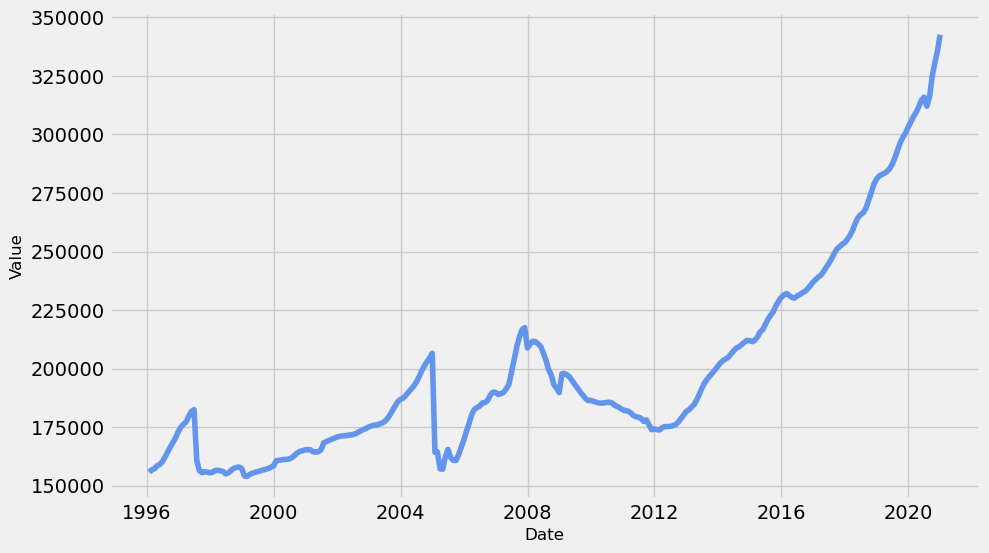

In [19]:
# Plot the new data set
plt.figure(figsize = (10,6))
plt.plot(Data_monthly, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Value', size = 12)
plt.show()

In [22]:
# Check for missing values (you shouldn't have any)

Data_monthly.isnull().sum()

value    0
dtype: int64

In [23]:
# Check for duplicates

dups = Data_monthly.duplicated()
dups.sum()

0

### Time-series analysis: decomposition

In [25]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(Data_monthly, model='additive', period=1)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [26]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

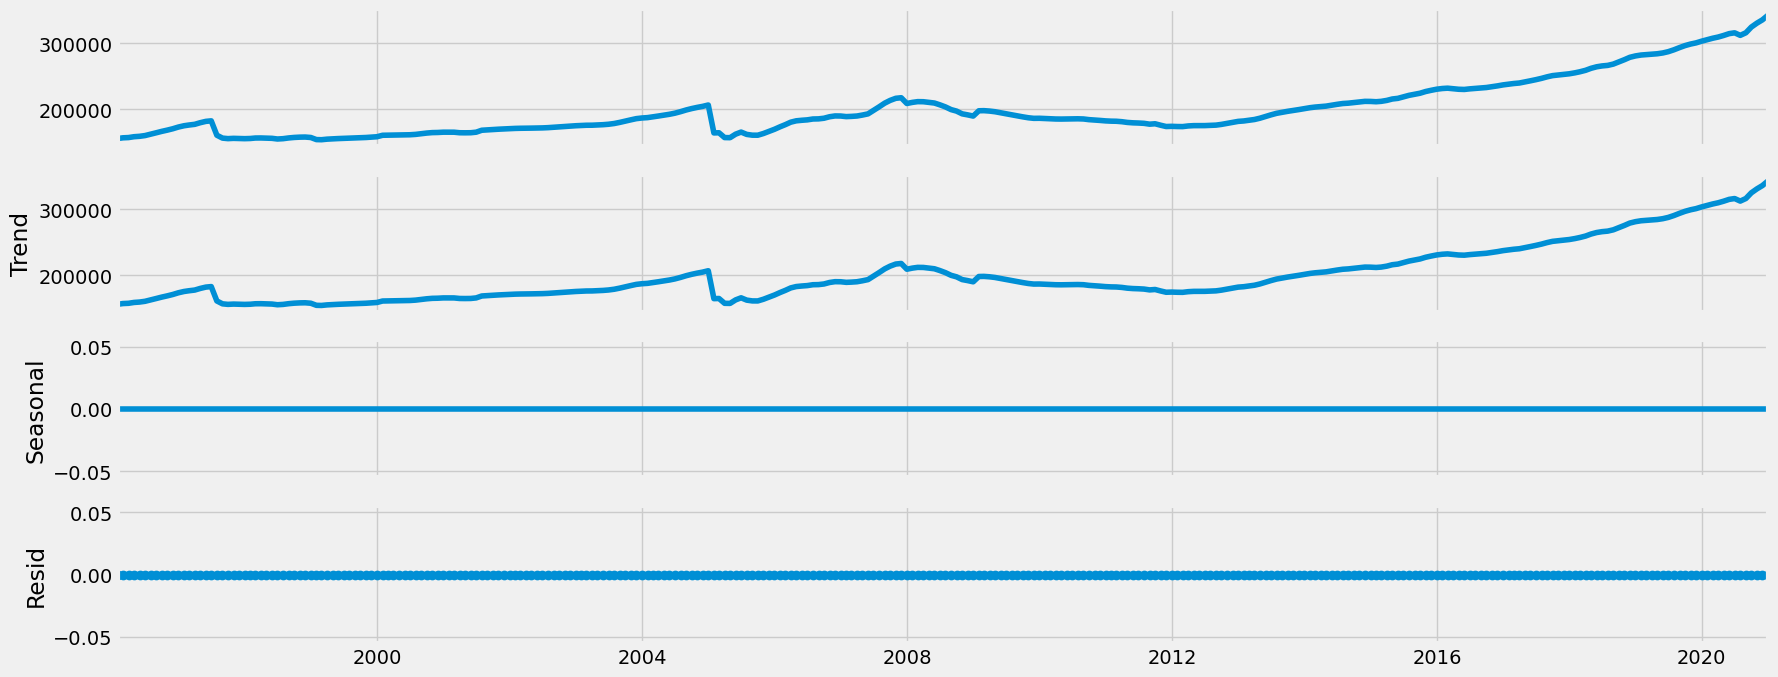

In [27]:
# Plot the separate components

decomposition.plot()
plt.show()

## Interpretation of the Decomposition and trend

#Time series decomposition helps us break down a time series dataset into three main components, By separating these components, we can gain insights into the behavior of the data and make better forecasts.

#Trend: The trend component represents the long-term movement in the data, representing the underlying pattern.

#Seasonality: The seasonality component represents the repeating, short-term fluctuations caused by factors like seasons or cycles, from the dataset there is no seasonality associated with the dataset.

#Residual (Noise): After removing the trend and seasonality, the residual component represents random variability.



# Testing for stationarity

In [28]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(Data_monthly['value'])

Dickey-Fuller Stationarity test:
Test Statistic                   2.075746
p-value                          0.998764
Number of Lags Used              2.000000
Number of Observations Used    297.000000
Critical Value (1%)             -3.452561
Critical Value (5%)             -2.871321
Critical Value (10%)            -2.571982
dtype: float64


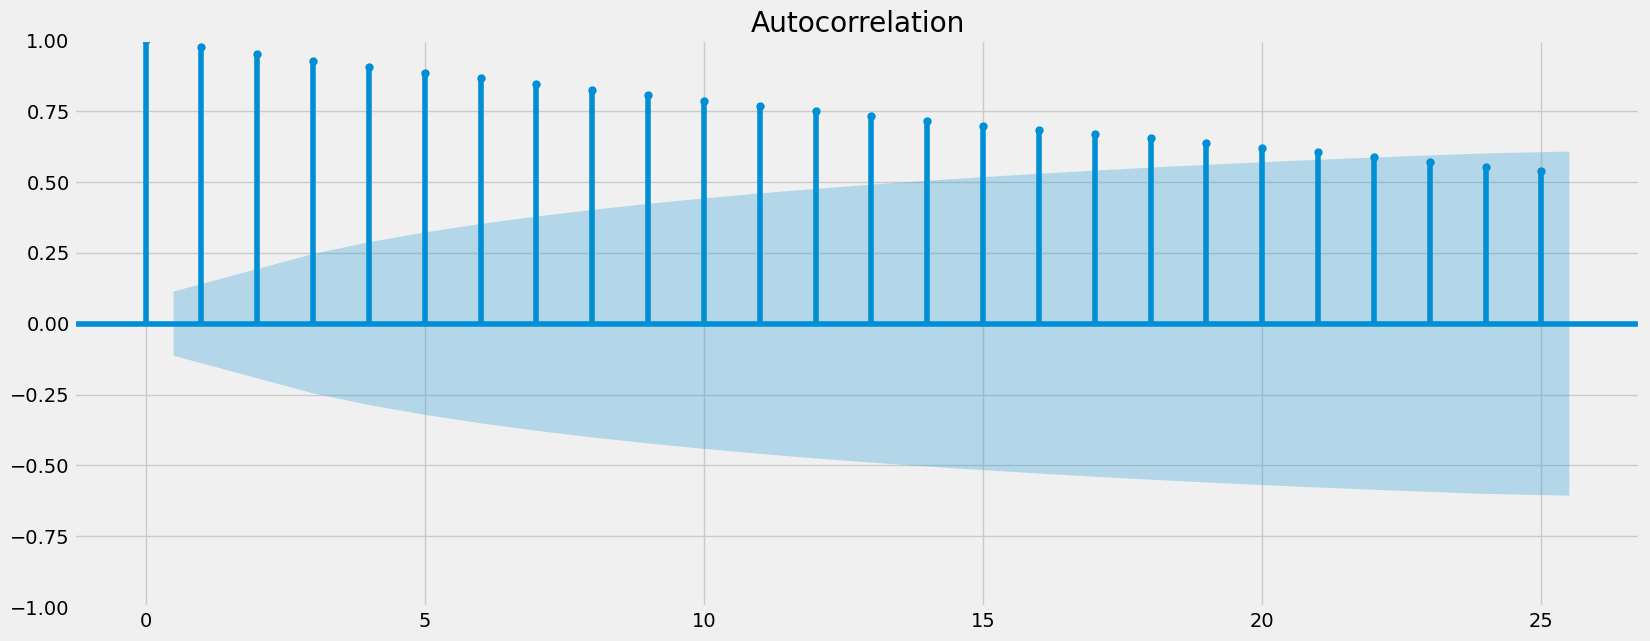

In [29]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(Data_monthly)
plt.show()

# Observations: The Dickey-Fuller test that we condacted shows that this time series are non - stationarity.
#The Critical Value (10%) is -2.571982, which is bigger than the Statistic Test of 2.075746.
#Also the p - value of 0.998764, indicated that the test result is not significant

#Stationarizing Differencing testing

In [30]:
# Differencing

data_diff = Data_monthly - Data_monthly.shift(1)

In [31]:
# Remove the missing values that came about as a result of the differencing

data_diff.dropna(inplace = True) 

In [32]:
data_diff.head()

,value
date,
1996-02-29,1098.0
1996-03-31,394.0
1996-04-30,1276.0
1996-05-31,618.0
1996-06-30,1137.0


In [33]:
data_diff.columns

Index(['value'], dtype='object')

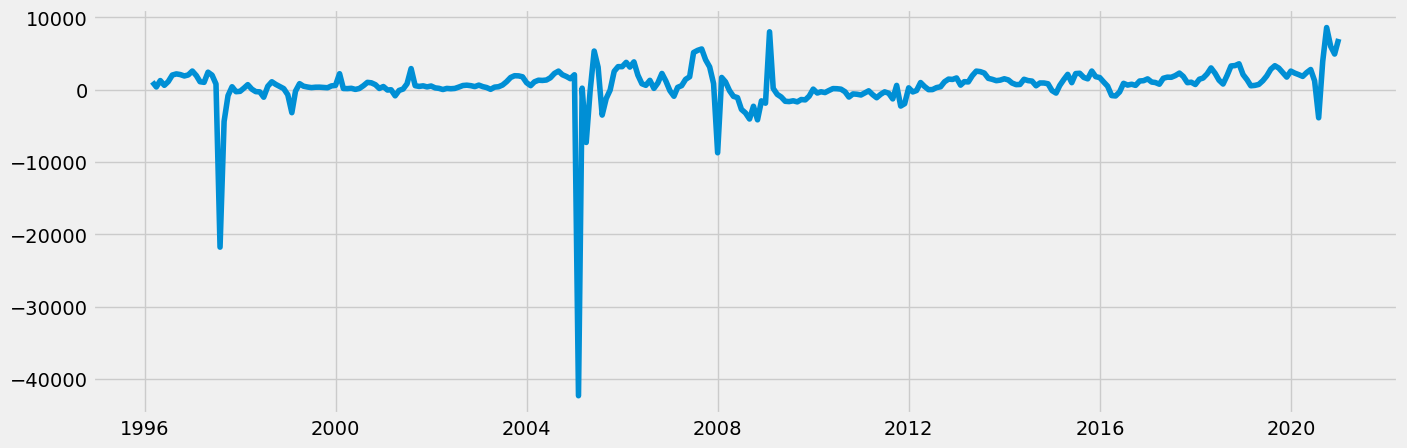

In [34]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [35]:
# Run Dickey-Fuller test for stationarity 

dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -9.258419e+00
p-value                        1.428720e-15
Number of Lags Used            1.000000e+00
Number of Observations Used    2.970000e+02
Critical Value (1%)           -3.452561e+00
Critical Value (5%)           -2.871321e+00
Critical Value (10%)          -2.571982e+00
dtype: float64


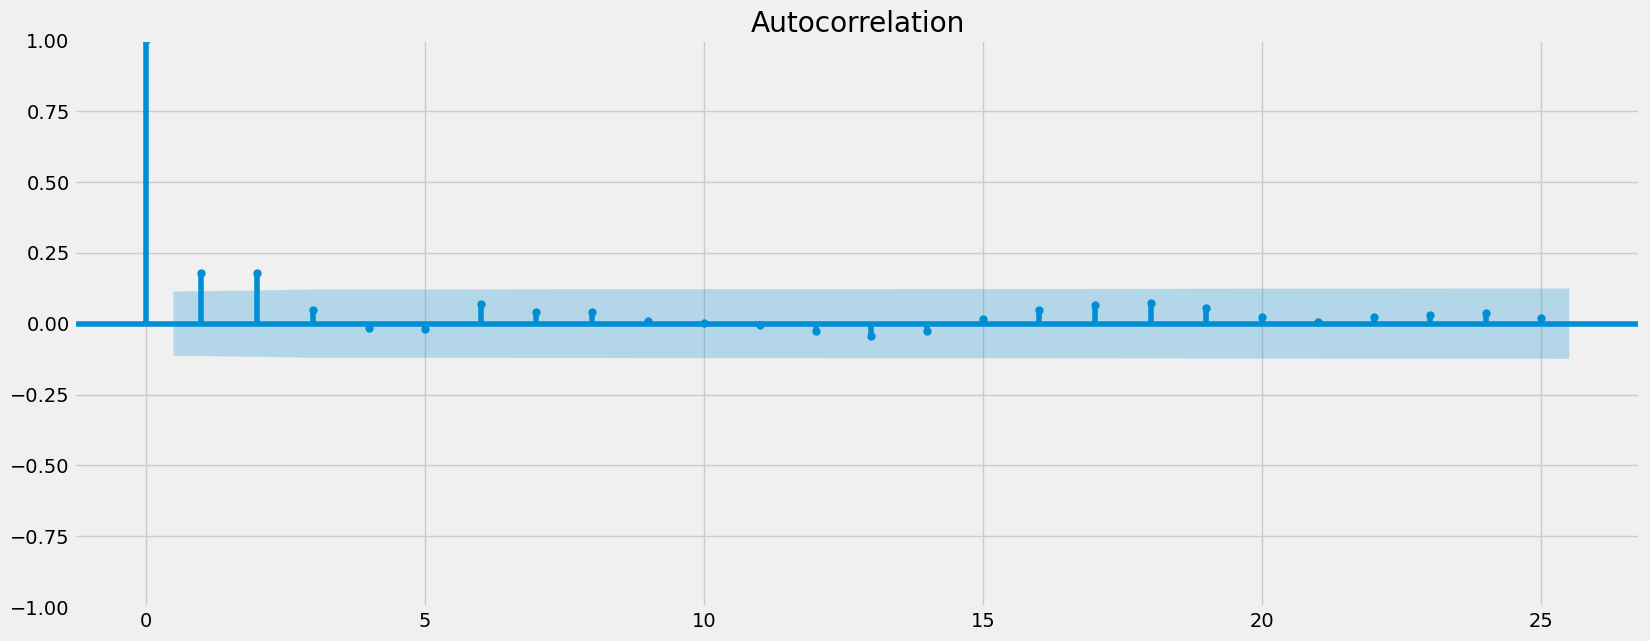

In [36]:
# Check out the autocorrelation plot

plot_acf(data_diff)
plt.show()

In [37]:
# Run a second round of differencing

data_diff_2 = data_diff - data_diff.shift(1)

In [38]:
# Remove the missing values that came about as a result of the differencing

data_diff_2.dropna(inplace = True) 

In [39]:
data_diff_2.head()

,value
date,
1996-03-31,-704.0
1996-04-30,882.0
1996-05-31,-658.0
1996-06-30,519.0
1996-07-31,904.0


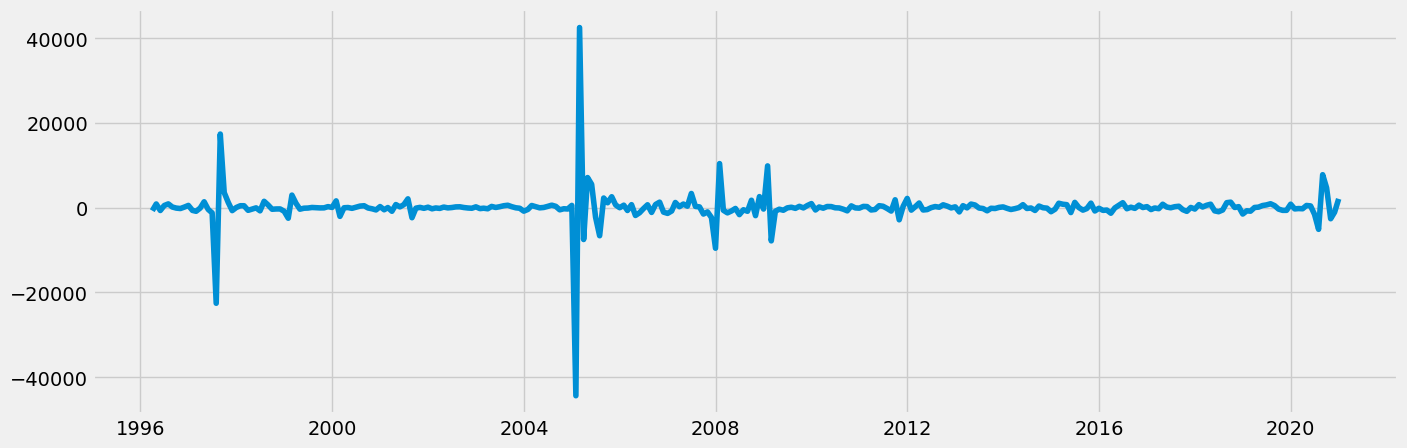

In [40]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [41]:
# Run Dickey-Fuller test for stationarity 

dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                -8.490089e+00
p-value                        1.320635e-13
Number of Lags Used            9.000000e+00
Number of Observations Used    2.880000e+02
Critical Value (1%)           -3.453262e+00
Critical Value (5%)           -2.871628e+00
Critical Value (10%)          -2.572146e+00
dtype: float64


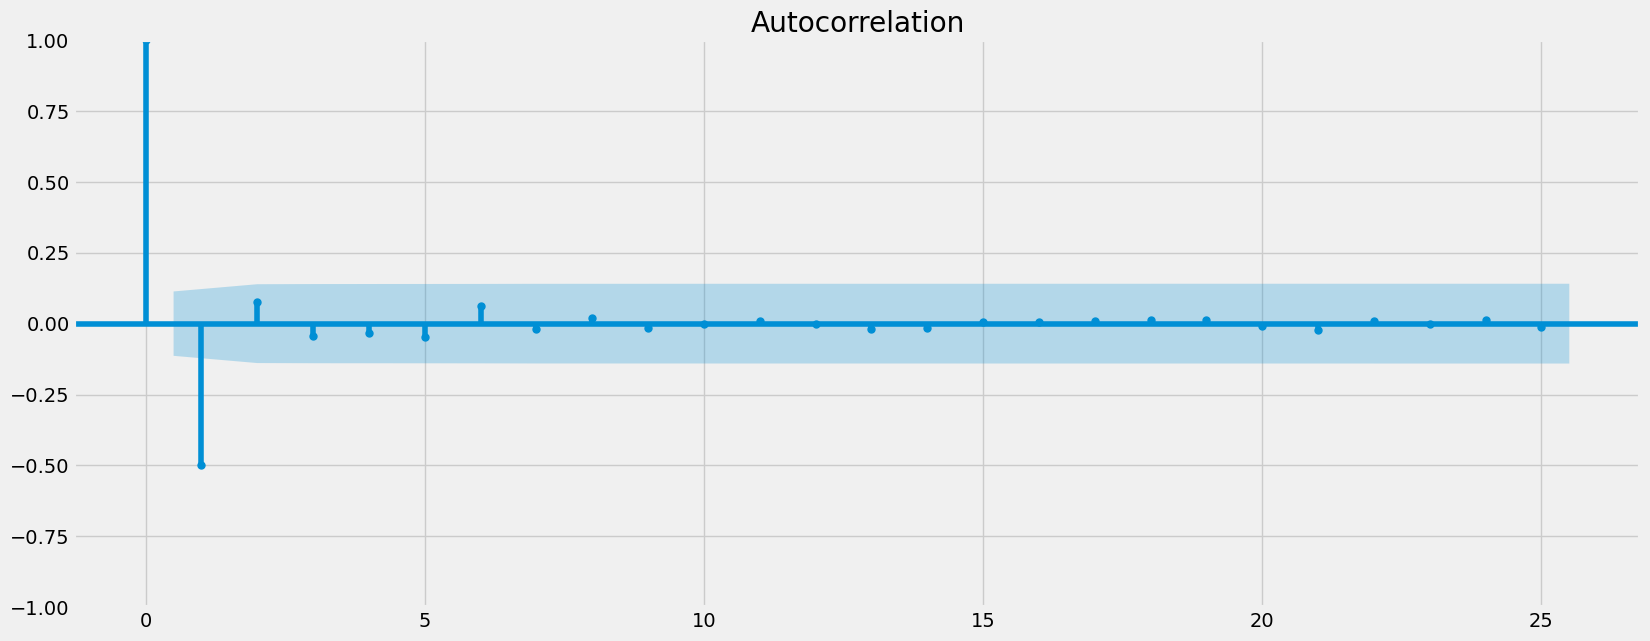

In [42]:
# Recheck the data’s autocorrelations

plot_acf(data_diff_2)
plt.show()

In [ ]:
#interprestation of the difference testing

#the test statistic is now bigger than the critical value at both the five and ten percent significance levels for difference testing 

#we have a p-value 1.4 and 1.3 respectively, This means you we can’t reject the null hypothesis and, as a result, consider your series stationary.